In [18]:
# importing the required modules

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [19]:
# Load the data
train_dta = pd.read_csv('../../data/breast_cancer/breast_cancer_data_train.csv')
test_dta = pd.read_csv('../../data/breast_cancer/breast_cancer_data_test.csv')
train_dta.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,859471,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,...,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750,0
1,873593,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,...,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840,1
2,859196,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,...,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490,0
3,88466802,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,...,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147,0
4,858970,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,...,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020,0


In [20]:
# splitting the data into features and target
X_train = train_dta.drop(['diagnosis'], axis=1)
y_train = train_dta['diagnosis']

X_test = test_dta.drop(['diagnosis'], axis=1)
y_test = test_dta['diagnosis']

In [21]:
# splitting the data into features and target
X_train = train_dta.drop(['diagnosis'], axis=1)
y_train = train_dta['diagnosis']

X_test = test_dta.drop(['diagnosis'], axis=1)
y_test = test_dta['diagnosis']

In [22]:
# # scaling the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [23]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize each row individually
def tokenize_row(row, tokenizer):
    # Convert the row to string, as BERT expects textual input
    row_str = " ".join(map(str, row.values))
    inputs = tokenizer(row_str, padding='max_length', truncation=True, return_tensors="pt")
    return inputs

# Tokenize the training and testing data
train_inputs = [tokenize_row(row, tokenizer) for _, row in train_dta.iterrows()]
test_inputs = [tokenize_row(row, tokenizer) for _, row in test_dta.iterrows()]

c:\Users\lenovo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
class BreastCancerDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = self.inputs[idx]['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = self.inputs[idx]['attention_mask'].squeeze(0)
        label = torch.tensor(self.labels[idx])
        return input_ids, attention_mask, label

# Create dataset and dataloader
train_dataset = BreastCancerDataset(train_inputs, y_train)
test_dataset = BreastCancerDataset(test_inputs, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [25]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training function with gradient accumulation
def train(model, train_loader, optimizer, accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(train_loader):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    return total_loss / len(train_loader)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    avg_loss = train(model, train_loader, optimizer)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\lenovo\anaconda3\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10, Loss: 0.6689
Epoch 2/10, Loss: 0.6430
Epoch 3/10, Loss: 0.4387
Epoch 4/10, Loss: 0.0986
Epoch 5/10, Loss: 0.0212
Epoch 6/10, Loss: 0.0057
Epoch 7/10, Loss: 0.0043
Epoch 8/10, Loss: 0.0018
Epoch 9/10, Loss: 0.0013
Epoch 10/10, Loss: 0.0010


In [26]:
# Get Predictions

# Function to get predictions
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, _ = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, pred = torch.max(outputs.logits, dim=1)
            predictions.extend(pred.cpu().numpy())
    return predictions

# Get predictions on test set
test_predictions = get_predictions(model, test_loader)

# save predictions to results folder names bert.csv
pd.DataFrame(test_predictions).to_csv('results/bert.csv', index=False)


In [27]:
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_examples = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            total_correct += (predictions == labels).sum().item()
            total_examples += labels.size(0)
    accuracy = total_correct / total_examples
    return accuracy

# Evaluate the model
accuracy = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 1.0000


In [28]:
# create a confusion matrix to evaluate the model
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate_confusion_matrix(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    return confusion_matrix(actuals, predictions)

conf_matrix = evaluate_confusion_matrix(model, test_loader)
print(conf_matrix)

[[71  0]
 [ 0 43]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        43

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

ROC AUC Score: 1.0


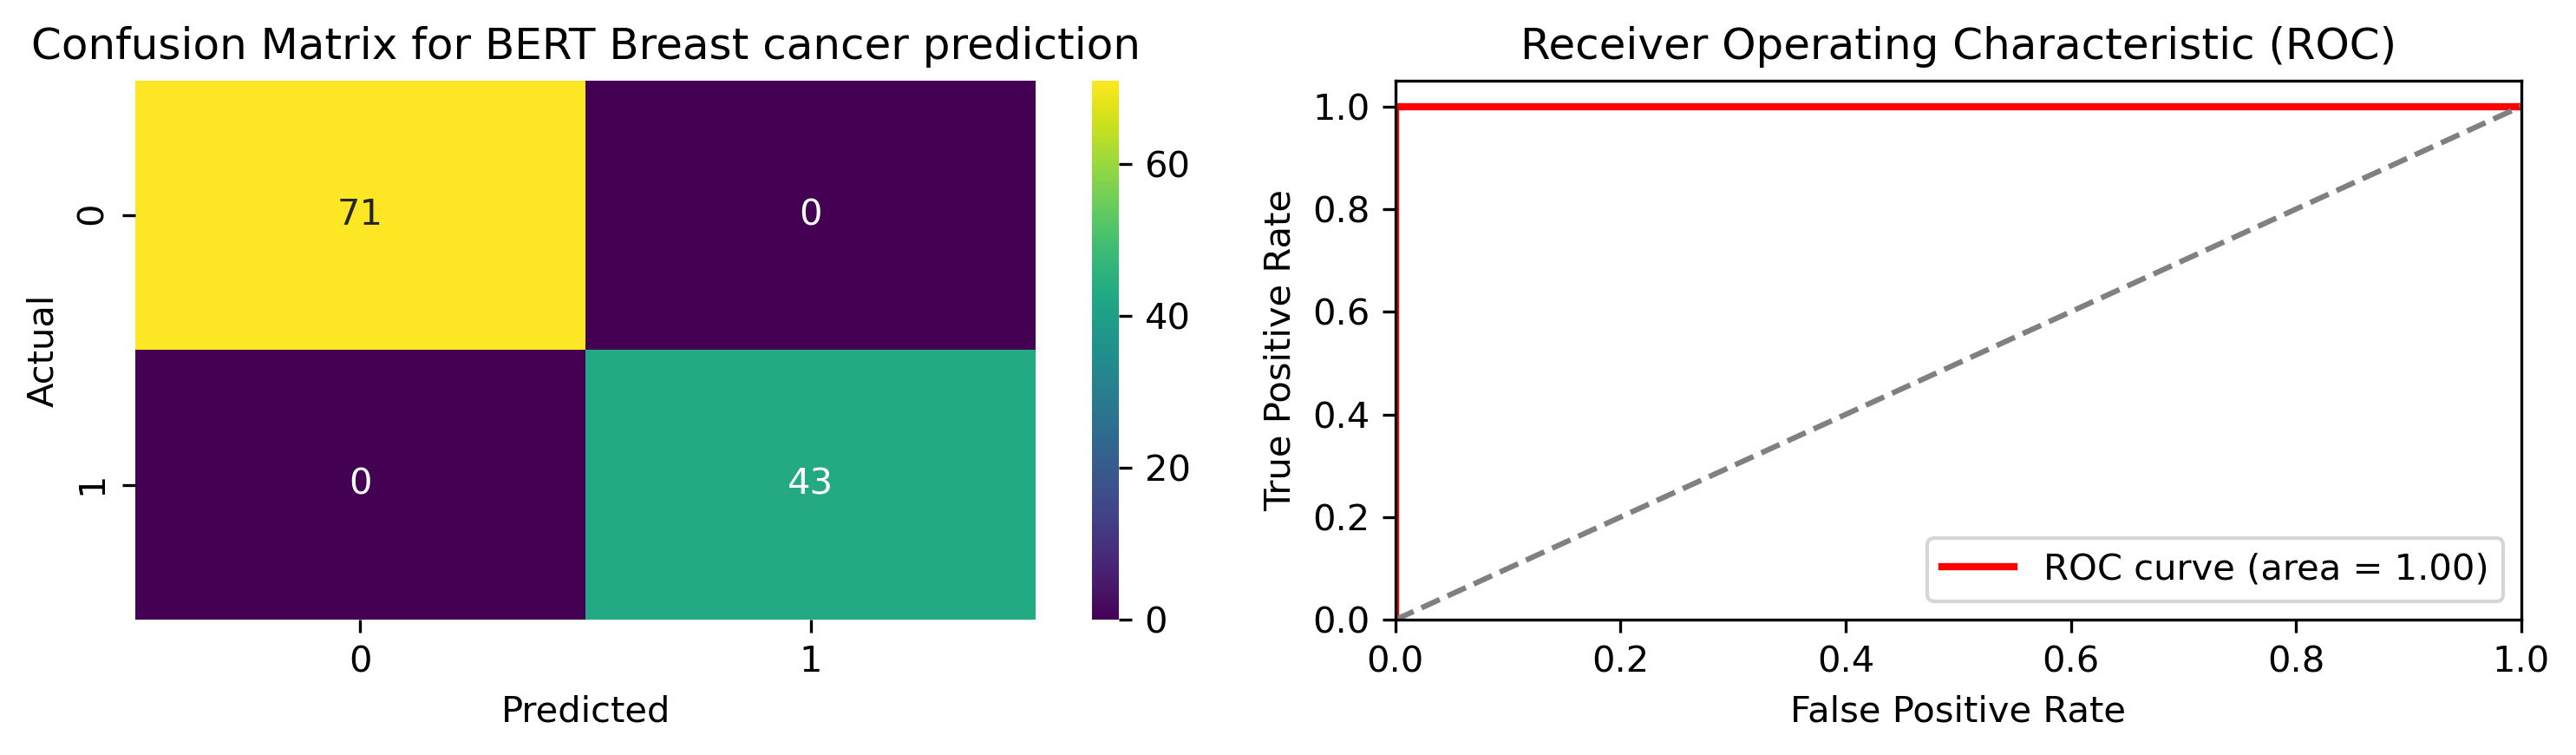

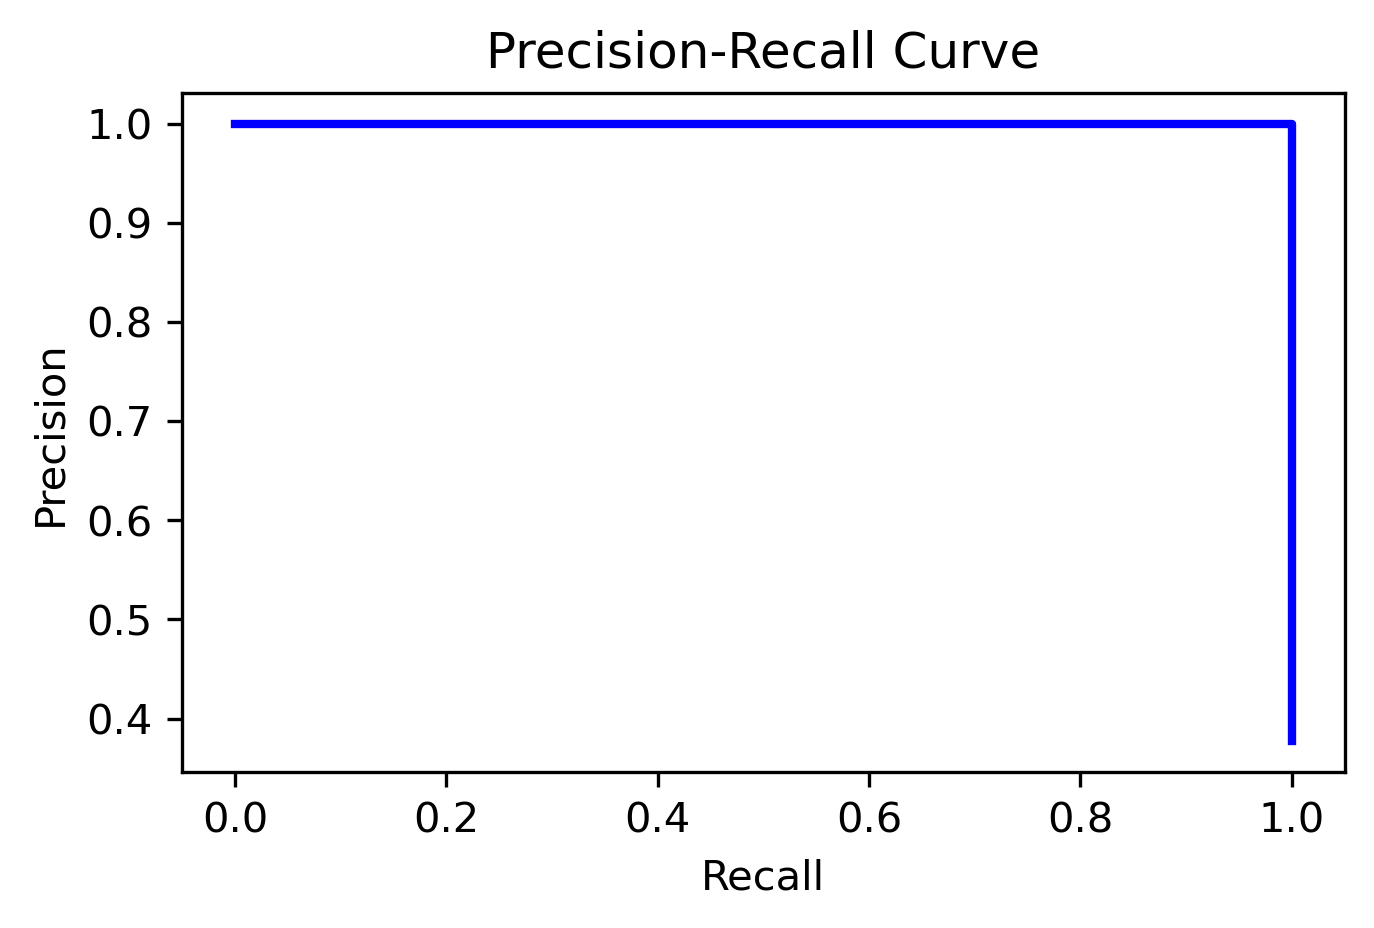

In [29]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Generating the classification report and AUC score from the traditional predictions and the target real
print(classification_report(y_test, test_predictions))
roc_auc = roc_auc_score(y_test, test_predictions)
print(f'ROC AUC Score: {roc_auc}')

# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
# Generating the ROC curve
fpr, tpr, _ = roc_curve(y_test, test_predictions)

# Generating the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, test_predictions)

# Plotting the ROC Curve and Confusion Matrix
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', ax=ax[0])
ax[0].set_title('Confusion Matrix for BERT Breast cancer prediction')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# ROC Curve
ax[1].plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Plotting the Precision-Recall Curve
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
